In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import tqdm
import json
%matplotlib inline

from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} will be used for training...")

cuda will be used for training...


In [4]:
train_data_path = os.path.join("..", "dataset", "prototyping", "train")
valid_data_path = os.path.join("..", "dataset", "prototyping", "valid")
test_data_path = os.path.join("..", "dataset", "prototyping", "valid")
print(f"Train path: {train_data_path}\nValid path: {valid_data_path}\nTrain Path: {train_data_path}")

Train path: ..\dataset\data\train
Valid path: ..\dataset\data\valid
Train Path: ..\dataset\data\train


# 1. Defining Transforms for Data Augumentation

In [5]:
image_size = 256
batch_size = 32

train_transforms = v2.Compose([
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(15),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
training_data = ImageFolder(train_data_path, transform=train_transforms)
valid_data = ImageFolder(valid_data_path, transform=test_transforms)
test_data = ImageFolder(test_data_path, transform=test_transforms)

In [7]:
def make_weights_for_balanced_classes(images, nclasses):
    # n_images = len(images)

    # print("Counting class frequencies", flush=True)
    # count_per_class = Counter(image_class for _, image_class in tqdm.tqdm(images))
    # print(f"Counts: {count_per_class}", flush=True)

    print("Calculating weights...", flush=True)
    weight_per_class = {0: 1.1948951686, 1: 6.1309635173}

    print("Assigning weights...", flush=True)
    weights = [weight_per_class[image_class] for _, image_class in tqdm.tqdm(images)]

    return weights

In [8]:
if os.path.exists("weights.json"):
    with open("weights.json", "r") as f:
        weights = json.load(f)["weights"]
else:
    weights = make_weights_for_balanced_classes(training_data, 2)

In [9]:
set(weights)

{1.1948951686, 6.1309635173}

In [10]:
if not os.path.exists("weights.json"):
    class_weights_path = "./weights.json"
    class_weights = {"weights": weights}

    with open(class_weights_path, "w") as file:
        json.dump(class_weights, file)

In [11]:
from torch.utils.data.sampler import WeightedRandomSampler

weights = torch.DoubleTensor(weights)
training_sampler = WeightedRandomSampler(weights, len(weights))

In [12]:
train_loader = DataLoader(training_data, batch_size=batch_size, sampler=training_sampler)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [13]:
idx_to_class = {v: k for k, v in training_data.class_to_idx.items()}
idx_to_class

{0: 'fake', 1: 'real'}

In [14]:
def display_image(img_tensor, title=None):
  image = img_tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image
  # image = image.clip(0, 1)

  if title:
    plt.title(title)

  plt.imshow(image)
  plt.show()

def plot_double_line(x, y1, y2, title="", y1label="", y2label="", xlab="", ylab=""):
  plt.plot(x, y1, label=y1label)
  plt.plot(x, y2, label=y2label)

  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.legend()
  plt.title(title)
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5125442].


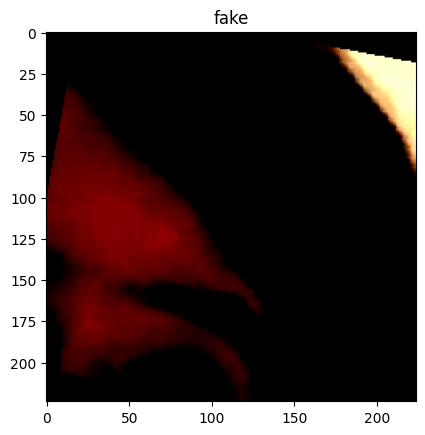

In [15]:
images, labels = next(iter(train_loader))
display_image(images[0], idx_to_class[labels[0].item()])

In [16]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)
model

d:\Programming\Hackathons\SPS Cup\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Programming\Hackathons\SPS Cup\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
# [I 2024-12-23 01:29:01,081] Trial 14 finished with value: 0.735 and parameters: {'n_layers': 2, 'learning_rate': 0.002571768221420213, 'dropout_rate': 0.18647655711328523, 'n_units_l0': 1216, 'n_units_l1': 2005}. Best is trial 14 with value: 0.735.
# for param in model.parameters():
#     param.requires_grad = False

dropout_rate = 0.18

# classifier = torch.nn.Sequential(
#     nn.Linear(512, 2),
#     nn.ReLU(),
#     nn.Dropout(p=dropout_rate),
#     nn.Linear(1024, 2),
#     # nn.ReLU(),
#     # nn.Dropout(p=dropout_rate),
#     # nn.Linear(2048, 2),
# )

classifier = nn.Linear(model.fc.in_features, 2)

model.fc = classifier
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
if not os.path.exists("../checkpoints"):
    os.makedirs("../checkpoints")

In [19]:
latest_checkpoint_path = os.path.join("..", "checkpoints", "latest_model.pt")
best_checkpoint_path = os.path.join("..", "checkpoints", "best_model.pt")

# Loading the checkpoint and necessary stuff

In [29]:
checkpoint = None
if os.path.exists(latest_checkpoint_path):
    checkpoint = torch.load(latest_checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])
    print("Latest model loaded...")
    print(f"Epochs done: {checkpoint['number of epochs']}\nMinimum Validation Loss: {checkpoint['valid_loss']}")

C:\Users\navan\AppData\Local\Temp\ipykernel_23784\3679101632.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(latest_checkpoint_path)


Latest model loaded...
Epochs done: 18
Minimum Validation Loss: 0.10803605376788211


# Hyper parameters

In [20]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.1948951686, 6.1309635173]).to(device))
epochs = 200
learning_rate = 0.001
validate_every = 2

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
running_loss_array = [] if not checkpoint else checkpoint["running_loss_array"]
valid_loss_array = [] if not checkpoint else checkpoint["valid_loss_array"]
epoch_array = [] if not checkpoint else checkpoint["epoch_array"]
start_epoch = 0 if not checkpoint else checkpoint["number of epochs"]

In [33]:
# from collections import Counter

# sampled_classes = []
# for i, (data, target) in enumerate(train_loader):
#     sampled_classes.extend(target.tolist())
#     if i > 100:
#         break

# print(Counter(sampled_classes))

In [34]:
validation_loss_min = np.inf if not checkpoint else checkpoint["valid_loss"]
model.to(device)
model.train()

for e in range(start_epoch, epochs):
  running_loss = 0

  print(f"EPOCH {e + 1}:")
  i = 0
  for images, labels in tqdm.tqdm(train_loader):
    i += 1
    # print(f"{i} / {len(train_loader)} image being used for training")
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logps = model.forward(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"Epoch {e + 1} :: Running Loss: {running_loss / len(train_loader)}")

  current_model_state = {
    "state_dict": model.state_dict(),
    "valid_loss": validation_loss_min,
    "running_loss_array": running_loss_array,
    "valid_loss_array": valid_loss_array,
    "epoch_array": epoch_array,
    "number of epochs": e + 1,
  }

  validation_loss = 0

  if (e + 1) % validate_every == 0:
    epoch_array.append(e + 1)

    with torch.no_grad():
      model.eval()

      for images, labels in tqdm.tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)

        logps = model.forward(images)
        loss = criterion(logps, labels)

        validation_loss += loss.item()

    model.train()

    running_loss /= len(train_loader)
    validation_loss /= len(valid_loader)
    
    running_loss_array.append(running_loss)
    valid_loss_array.append(validation_loss)

    print(f"EPOCH {e + 1}:")
    print(f"Running Loss = {running_loss}\tValidation Loss: {validation_loss}")

    plot_double_line(epoch_array, running_loss_array, valid_loss_array, y1label="Running Loss", y2label="Validation Loss", xlab="Epochs", ylab="Loss")

    if validation_loss <= validation_loss_min:
      print(f"Minimum Validtion loss acquired, {validation_loss_min} to {validation_loss}")
      validation_loss_min = validation_loss
      current_model_state["valid_loss"] = validation_loss_min 
      torch.save(current_model_state, best_checkpoint_path)
  
  torch.save(current_model_state, latest_checkpoint_path)

EPOCH 19:


  0%|          | 18/7783 [00:07<54:02,  2.39it/s] 


KeyboardInterrupt: 

# Metrics Calculation

In [66]:
validation_loss = 0
correct_valid = 0
total_valid = 0

with torch.no_grad():
    model.eval()

    for images, labels in tqdm.tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)

        logps = model.forward(images)
        loss = criterion(logps, labels)
        validation_loss += loss.item()

        # Calculate validation accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        correct_valid += (top_class == labels.view(*top_class.shape)).sum().item()
        total_valid += labels.size(0)

validation_loss /= len(valid_loader)
validation_accuracy = correct_valid / total_valid * 100

print("Validation Accuracy:", validation_accuracy)

100%|██████████| 410/410 [00:51<00:00,  7.90it/s]

Validation Accuracy: 71.8339945071712


# Original Dataset Validation Accuracy

In [22]:
best_model_state = torch.load(latest_checkpoint_path)
model.load_state_dict(best_model_state["state_dict"])

C:\Users\navan\AppData\Local\Temp\ipykernel_7220\2102997454.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load(latest_checkpoint_path)


<All keys matched successfully>

In [23]:
validation_loss = 0
correct_valid = 0
total_valid = 0

model.to(device)

with torch.no_grad():
    model.eval()

    try:
        for images, labels in tqdm.tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            logps = model.forward(images)
            loss = criterion(logps, labels)
            validation_loss += loss.item()

            # Calculate validation accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            correct_valid += (top_class == labels.view(*top_class.shape)).sum().item()
            total_valid += labels.size(0)
    except Exception as e:
        pass

validation_loss /= len(valid_loader)
validation_accuracy = correct_valid / total_valid * 100
model.train()

print("Test Accuracy:", validation_accuracy)


100%|██████████| 96/96 [00:18<00:00,  5.25it/s]

Test Accuracy: 85.51432291666666


# Testing the model with images

In [41]:
from PIL import Image

In [44]:
image_path = r"..\dataset\prototyping\valid\real\valid_real_0010329.png"
image = Image.open(image_path).convert("RGB")
input_tensor = test_transforms(image).unsqueeze(0)

model.to(device)
model.eval()
input_tensor = input_tensor.to(device)

with torch.no_grad():
    output = model(input_tensor)

model.train()
output = torch.exp(output)
print("Output:", output)
predicted_class = torch.argmax(output, dim=1)
prediction = predicted_class.item()
print("Prediction:", idx_to_class[prediction])

Output: tensor([[ 0.0389, 24.7708]], device='cuda:0')
Prediction: real


# Model Parameter Counting

In [24]:
total_params = sum(p.numel() for p in model.parameters())
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params}\nTotal Trainable Parameters: {total_trainable_params}")

Total Parameters: 11177538
Total Trainable Parameters: 11177538


In [25]:
total_fc_params = sum(p.numel() for p in model.fc.parameters())
total_fc_trainable_params = sum(p.numel() for p in model.fc.parameters() if p.requires_grad)
print(f"Total FC Parameters: {total_fc_params}\nTotal FC Trainable Parameters: {total_fc_trainable_params}")

Total FC Parameters: 1026
Total FC Trainable Parameters: 1026


In [26]:
total_resnet_params = total_params - total_fc_params
total_resnet_trainable_params = total_trainable_params - total_fc_trainable_params
print(f"Total ResNet Parameters: {total_resnet_params}\nTotal ResNet Trainable Parameters: {total_resnet_trainable_params}")

Total ResNet Parameters: 11176512
Total ResNet Trainable Parameters: 11176512
